<a href="https://colab.research.google.com/github/Manuja001/DL_Lab_08/blob/main/Deep_Q_Learning_LunarLander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y swig
!pip install gymnasium[box2d] torch matplotlib numpy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 38 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 0s (3,421 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [ ]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
class DQNNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size=100000):
        self.memory = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
        )

    def __len__(self):
        return len(self.memory)

In [ ]:
def train_lunarlander(
    episodes=500,
    gamma=0.99,
    lr=0.001,
    batch_size=64,
    epsilon_start=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995,
    target_update=1000,
):

    env = gym.make("LunarLander-v3", render_mode=None)  # v3 environment
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_net = DQNNet(state_dim, action_dim).to(device)
    target_net = DQNNet(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayBuffer()
    epsilon = epsilon_start
    total_rewards = []
    epsilon_values = []
    step_count = 0
    losses = []

    for ep in range(episodes):
        state, _ = env.reset()  # Gymnasium v3 returns (state, info)
        total_reward = 0
        done = False

        while not done:
            step_count += 1
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                    q_vals = policy_net(state_tensor)
                    action = int(torch.argmax(q_vals).item())

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(memory) > batch_size:
                states, actions, rewards, next_states, dones = memory.sample(batch_size)
                states = torch.tensor(states, dtype=torch.float32).to(device)
                next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
                actions = torch.tensor(actions, dtype=torch.long).to(device)
                rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
                dones = torch.tensor(dones, dtype=torch.float32).to(device)

                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    targets = rewards + (1 - dones) * gamma * next_q_values

                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            if step_count % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        total_rewards.append(total_reward)
        epsilon_values.append(epsilon)

        if ep % 10 == 0:
            print(f"Episode {ep}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

    env.close()
    return total_rewards, epsilon_values, losses

Episode 0, Reward: -306.26, Epsilon: 0.995
Episode 10, Reward: -245.02, Epsilon: 0.946
Episode 20, Reward: -118.46, Epsilon: 0.900
Episode 30, Reward: -195.66, Epsilon: 0.856
Episode 40, Reward: -132.29, Epsilon: 0.814
Episode 50, Reward: -188.87, Epsilon: 0.774
Episode 60, Reward: -112.76, Epsilon: 0.737
Episode 70, Reward: 2.97, Epsilon: 0.701
Episode 80, Reward: -91.30, Epsilon: 0.666
Episode 90, Reward: -125.56, Epsilon: 0.634
Episode 100, Reward: -75.19, Epsilon: 0.603
Episode 110, Reward: -47.09, Epsilon: 0.573
Episode 120, Reward: -49.97, Epsilon: 0.545
Episode 130, Reward: 5.44, Epsilon: 0.519
Episode 140, Reward: -58.45, Epsilon: 0.493
Episode 150, Reward: -64.60, Epsilon: 0.469
Episode 160, Reward: -69.41, Epsilon: 0.446
Episode 170, Reward: -20.41, Epsilon: 0.424
Episode 180, Reward: -59.82, Epsilon: 0.404
Episode 190, Reward: 16.44, Epsilon: 0.384
Episode 200, Reward: 60.18, Epsilon: 0.365
Episode 210, Reward: 104.37, Epsilon: 0.347
Episode 220, Reward: 114.77, Epsilon: 0.3

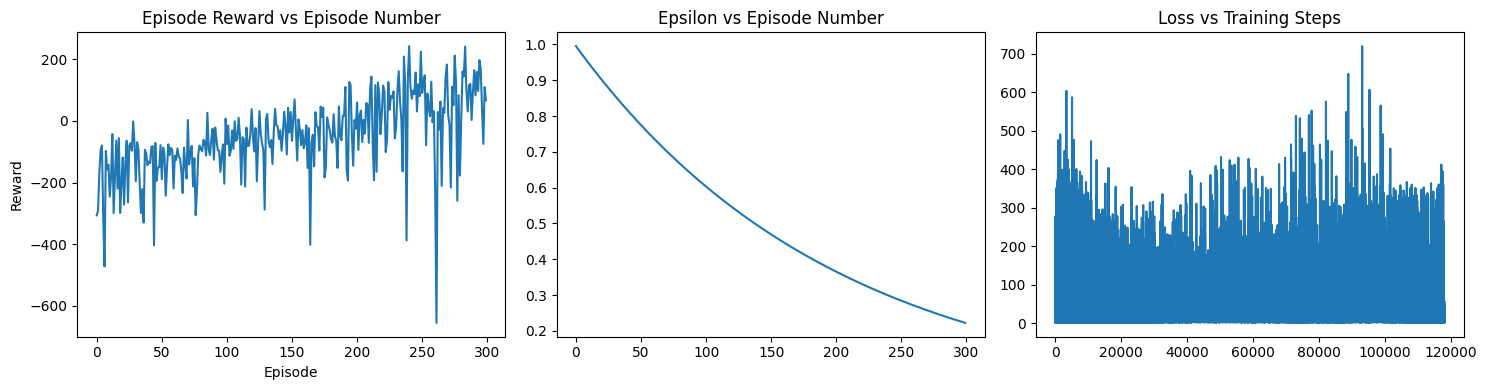

In [ ]:
rewards, eps_values, losses = train_lunarlander(episodes=300)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(rewards)
plt.title("Episode Reward vs Episode Number")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.subplot(1,3,2)
plt.plot(eps_values)
plt.title("Epsilon vs Episode Number")

plt.subplot(1,3,3)
plt.plot(losses)
plt.title("Loss vs Training Steps")
plt.tight_layout()
plt.show()